In [1]:
from functions import *

In [2]:
from music21 import converter, environment

# Set the paths to MuseScore executable
env = environment.Environment()
env['musicxmlPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'  # Path to MuseScore executable
env['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'  # Path to MuseScore executable

## Functions Overview

### extract_score_elements
Extracts elements from a music21 score object and organizes them into a DataFrame.

### recreate_score
Recreates a music21 score object from a DataFrame of score elements.

### parse_score_elements
Parses a music21 score object into a DataFrame of note attributes and a list of note and chord elements.

### calculate_ir_symbol
Calculates the IR (Intervallic Relationship) symbol based on the intervals between notes.

### assign_ir_symbols
Assigns IR symbols and colors to each element in the score array.

### visualize_notes_with_symbols
Visualizes notes with their assigned IR symbols and colors in a music21 score.

### ir_symbols_to_matrix
Assigns IR symbols to the note matrix based on the note array.

### assign_ir_pattern_indices
Assigns pattern indices to the note matrix based on IR symbols.

### get_onset
Retrieves the onset times from the note matrix.

### get_duration
Retrieves the duration times from the note matrix.

### calculate_clang_boundaries
Calculates clang boundaries based on note matrix attributes.

### calculate_segment_boundaries
Calculates segment boundaries based on clang boundaries and note attributes.

### adjust_segment_boundaries
Adjusts segment boundaries to ensure IR patterns are not split.

### segmentgestalt
Segments the note matrix into meaningful groups based on IR patterns and boundaries.

### segments_to_distance_matrix
Converts segments to a distance matrix using multiprocessing.

### segments_to_graph
Converts segments to a k-NN graph and ensures connectivity.


In [3]:
midi_file = '..\\bach_846.mid' # Hardcoded, for multiple songs, make a function to iterate thru folder
# midi_file = "..\\Music Database\\GTTM Database\\Alexander Porfir’evich Borodin\\Quartet for 2 Violins, Viola and Violoncello D major 3 Nocturne.xml"
# midi_file = ".\\Music Database\\bach_cello_suites\\Suite No. 1 in G major\\cs1-1pre.mid"
midi_parsed = converter.parse(midi_file)

In [4]:
# midi_parsed.show()

In [5]:
nmat, narr, sarr = parse_score_elements(midi_parsed)

In [7]:
ir_symbols = assign_ir_symbols(narr)

In [8]:
ir_nmat = ir_symbols_to_matrix(ir_symbols, nmat)

In [9]:
ir_nmat = assign_ir_pattern_indices(ir_nmat)

In [10]:
segments = segmentgestalt(ir_nmat)

In [11]:
processed_segments = preprocess_segments(segments)

In [13]:
def segments_to_distance_matrix(segments: list[pd.DataFrame], cores=None):
    if __name__ == '__main__':
        
        if cores is not None and cores > cpu_count():
            raise ValueError(f"You don't have enough cores! Please specify a value within your system's number of cores. \n Core Count: {cpu_count()}")
        
        seg_np = [segment.to_numpy() for segment in segments]
    
        num_segments = len(seg_np)
        distance_matrix = np.zeros((num_segments, num_segments))
    
        # Create argument list for multiprocessing
        args_list = []
        for i in range(num_segments):
            for j in range(i + 1, num_segments):
                args_list.append((i, j, segments[i], segments[j]))
    
        with Manager() as manager:
            message_list = manager.list()
    
            def log_message(message):
                message_list.append(message)
    
            # Use multiprocessing Pool to parallelize the calculations
            with Pool() as pool:
                results = pool.map(worker.calculate_distance, args_list)
    
            # Update distance matrix with the results
            for i, j, distance, message in results:
                distance_matrix[i, j] = distance
                distance_matrix[j, i] = distance  # Reflect along the diagonal
                log_message(message)
    
            # Print messages from the shared list
            for message in message_list:
                print(message)
    
        return distance_matrix

In [14]:
distance_matrix = segments_to_distance_matrix(processed_segments)

Calculated Edge Weight (0, 1)
Calculated Edge Weight (0, 2)
Calculated Edge Weight (0, 3)
Calculated Edge Weight (0, 4)
Calculated Edge Weight (0, 5)
Calculated Edge Weight (0, 6)
Calculated Edge Weight (0, 7)
Calculated Edge Weight (0, 8)
Calculated Edge Weight (0, 9)
Calculated Edge Weight (0, 10)
Calculated Edge Weight (0, 11)
Calculated Edge Weight (0, 12)
Calculated Edge Weight (0, 13)
Calculated Edge Weight (0, 14)
Calculated Edge Weight (0, 15)
Calculated Edge Weight (0, 16)
Calculated Edge Weight (0, 17)
Calculated Edge Weight (0, 18)
Calculated Edge Weight (0, 19)
Calculated Edge Weight (0, 20)
Calculated Edge Weight (0, 21)
Calculated Edge Weight (0, 22)
Calculated Edge Weight (0, 23)
Calculated Edge Weight (0, 24)
Calculated Edge Weight (0, 25)
Calculated Edge Weight (0, 26)
Calculated Edge Weight (0, 27)
Calculated Edge Weight (0, 28)
Calculated Edge Weight (0, 29)
Calculated Edge Weight (0, 30)
Calculated Edge Weight (0, 31)
Calculated Edge Weight (0, 32)
Calculated Edge W

In [17]:
# distance matrix to knn graph function
def distance_matrix_to_knn_graph(k: int, distance_matrix: np.array, graph_title: str,
                                 seed: int, iterations: int):
  knn_graph = kneighbors_graph(distance_matrix, n_neighbors=k, mode='connectivity')

  G = nx.from_scipy_sparse_array(knn_graph)

  # Detect if the graph is disjoint
  if not nx.is_connected(G):
      print("The KNN graph is disjoint. Ensuring connectivity...")

      # Calculate the connected components
      components = list(nx.connected_components(G))

      # Connect the components
      for i in range(len(components) - 1):
          min_dist = np.inf
          closest_pair = None
          for node1 in components[i]:
              for node2 in components[i + 1]:
                  dist = distance_matrix[node1, node2]
                  if dist < min_dist:
                      min_dist = dist
                      closest_pair = (node1, node2)

          # Add an edge between the closest pair of nodes from different components
          G.add_edge(closest_pair[0], closest_pair[1])

  # Plot the final connected graph
  pos = nx.spring_layout(G, seed=seed, iterations=iterations)
  nx.draw(G, node_size=50, pos=pos)
  plt.title(graph_title + f" (K={k})")
  plt.show()

The KNN graph is disjoint. Ensuring connectivity...


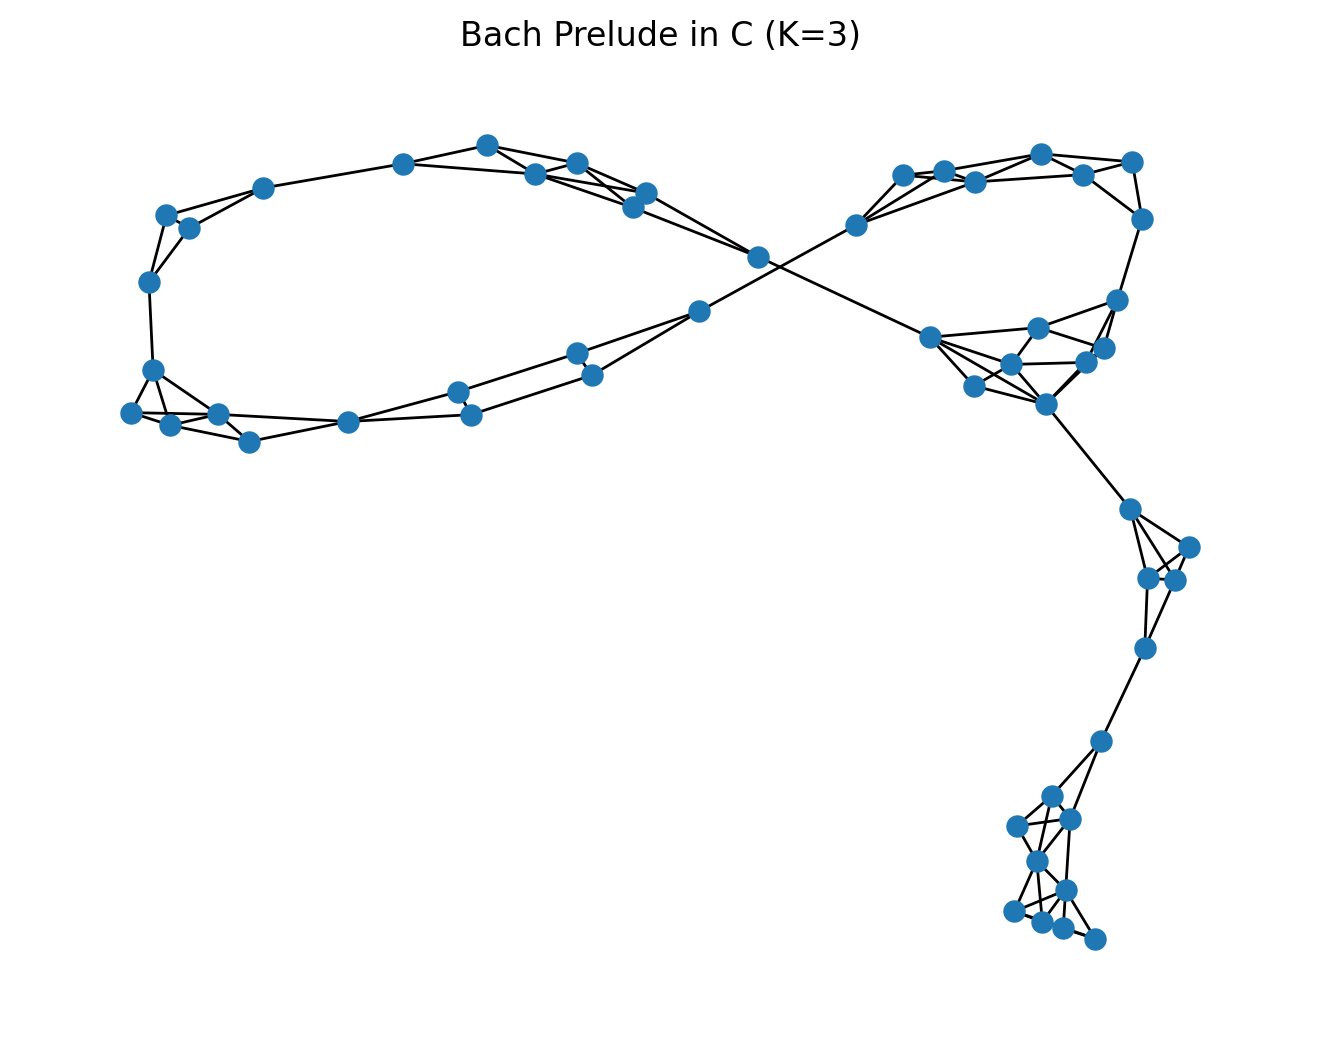

In [24]:
# show graph
distance_matrix_to_knn_graph(3, distance_matrix, "Bach Prelude in C", 9, 50)

In [ ]:
# segments to graph function
def segments_to_graph(k: int, segments: list[pd.DataFrame], labeled_segments, cores=None):
  # Convert segments to a distance matrix
  distance_matrix = segments_to_distance_matrix(segments, cores=cores)

  # Compute the k-NN graph
  knn_graph = kneighbors_graph(distance_matrix, n_neighbors=k, mode='connectivity')

  # Convert the k-NN graph to a NetworkX graph
  G = nx.from_scipy_sparse_array(knn_graph)

  # Add segment data as attributes to each node
  for i in range(len(segments)):
    G.nodes[i]['segment'] = labeled_segments[i] # print shit

  # Detect if the graph is disjoint
  if not nx.is_connected(G):
      print("The KNN graph is disjoint. Ensuring connectivity...")

      # Calculate the connected components
      components = list(nx.connected_components(G))

      # Connect the components
      for i in range(len(components) - 1):
          min_dist = np.inf
          closest_pair = None
          for node1 in components[i]:
              for node2 in components[i + 1]:
                  dist = distance_matrix[node1, node2]
                  if dist < min_dist:
                      min_dist = dist
                      closest_pair = (node1, node2)

          # Add an edge between the closest pair of nodes from different components
          G.add_edge(closest_pair[0], closest_pair[1])

  return G, distance_matrix

In [ ]:
# segments to graph
graph, distance_matrix = segments_to_graph(5, segments, labeled_segments)